## Definition/Data

### Imports

In [1]:
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from sklearn import metrics
from torch.autograd import Function
from torch.optim import Adam
from graphviz import Source
from pyeda.boolalg.bdd import bdd2expr

filepath = os.path.abspath('')
sys.path.append(os.path.join(filepath, "..", "..", "compiling_nn"))
from build_odd import compile_nn

pd.options.mode.copy_on_write = True

In [2]:
def plot_cm(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=[False, True])
    cm_display.plot()

def tnot(a): return torch.logical_not(a)
def tor(a,b): return torch.logical_or(a,b)
def tand(a,b): return torch.logical_and(a,b)
def txor(a,b): return torch.logical_xor(a,b)

### Networks class and Custom Activation/Loss

In [3]:
class BigNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        x = self.nn(x)
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,1),
            StepActivation()
        )

    def forward(self, x):
        x = self.nn(x)
        return x
    
######################################################

class StepFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input>=0, torch.tensor(1.0), torch.tensor(0.0))
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        return grad_input
    
class StepActivation(nn.Module):
    def forward(self, input):
        if self.training:
            return torch.sigmoid(input)
        else:
            return StepFunction.apply(input)

class ExpLoss(nn.Module): # https://www.desmos.com/calculator/1gtkyr1dlm
    def __init__(self, lower_bound=0, upper_bound=1, b=1.00, base_pow=None, reduction='mean'):
        super(ExpLoss, self).__init__()
        self.coef_div = upper_bound - lower_bound
        self.coef_mul = b
        self.coef_all = self.coef_mul/self.coef_div
        self.base_pow = base_pow

        self.mean_reduction = reduction=='mean'
        self.sum_reduction = reduction=='sum'

    def forward(self, input, label):
        if self.base_pow:
            loss = torch.abs(torch.pow(exponent=(input - label)*self.coef_all, self=self.base_pow) - 1)
        else:
            loss = torch.abs(torch.exp((input - label)*self.coef_all) - 1)

        if self.mean_reduction:
            loss = torch.mean(loss)
        elif self.sum_reduction:
            loss = torch.sum(loss)

        return loss
    
class AsymMSELoss(nn.Module): # https://www.desmos.com/calculator/zmxcluqhkt
    def __init__(self, p=2):
        super(AsymMSELoss, self).__init__()
        self.p = p

    def forward(self, input, label):
        dif = label - input
        a = torch.square(dif)
        b = a*self.p
        loss = torch.where(dif < 0, b, a)
        loss = torch.mean(loss)
        return loss

### Data preprocessing

In [4]:
df = pd.read_csv("loan_data_set.csv", sep=",")
df = df.drop(columns=["Loan_ID"])

# Remove above 98.5th percentile for 'ApplicantIncome' and 'CoapplicantIncome'
df_rank = df[["ApplicantIncome", "CoapplicantIncome"]]
df_rank["rankA"] = df_rank[["ApplicantIncome"]].rank(pct=True)
df_rank["rankCo"] = df_rank["CoapplicantIncome"].rank(pct=True)

df = df.loc[(df_rank["rankA"]<=0.985) & (df_rank["rankCo"]<=0.985)]
df.index = range(len(df))

# Transform using hot encoding
df_y = pd.get_dummies(df[["Loan_Status"]], drop_first=True)
df_x = df.drop(columns=["Loan_Status"])

nunique = df_x.nunique(axis=0)
df_x_mean = df_x.mean(axis=0, numeric_only=True)

for col, n in nunique.items():
    if n > 4:
        df_x[col] = df_x[col].apply(lambda x : min(4, x//(.5*df_x_mean[col])))

df_x = pd.get_dummies(df_x, columns=df_x.columns, drop_first=True)

# Balance dataset
itrue = df_y.index[df_y["Loan_Status_Y"]==1].tolist()
ifalse = df_y.index[df_y["Loan_Status_Y"]==0].tolist()

swap = len(itrue) > len(ifalse)
if swap:
    itrue,ifalse=ifalse,itrue

ifalse = random.choices(ifalse, k=len(itrue))

if swap:
    itrue,ifalse=ifalse,itrue

print(df_y.iloc[itrue+ifalse].value_counts())

x_train=torch.Tensor(df_x.iloc[itrue+ifalse].to_numpy(dtype=int))
y_train=torch.Tensor(df_y.iloc[itrue+ifalse].to_numpy(dtype=int))

print(x_train.shape, y_train.shape)

Loan_Status_Y
0                184
1                184
dtype: int64
torch.Size([368, 25]) torch.Size([368, 1])


## Separate Training

### Big Network

In [5]:
%%script true

bignet = BigNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn = nn.BCELoss()
optimizer = Adam(bignet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bignet.train()
    y_pred = bignet(x_train)
    loss = loss_fn(y_pred, y_train)

    bignet.zero_grad()
    loss.backward()
    optimizer.step()

    bignet.eval()
    y_pred_step = bignet(x_train)
    loss_step = loss_fn(y_pred_step, y_train)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

In [6]:
%%script true

bignet.eval()
y_pred_big = bignet(x_train).detach().numpy()
plot_cm(y_train, y_pred_big)
plt.show()

### Small Network with Custom Loss (ExpLoss)

In [7]:
%%script true

smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = ExpLoss(base_pow=1.5, upper_bound=1, lower_bound=0)
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.maximum(bignet(x_train), y_train).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x_train)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x_train)
    loss_step = loss_fn_small(y_pred_step_small, y_train)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

In [8]:
%%script true

smallnet.eval()
y_pred_small = smallnet(x_train).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y_train, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

### Small Network with BCELoss

In [9]:
%%script true

smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = nn.BCELoss()
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.minimum(bignet(x_train), y_train).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x_train)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x_train)
    loss_step = loss_fn(y_pred_step_small, y_train)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

In [10]:
%%script true

smallnet.eval()
y_pred_small = smallnet(x_train).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y_train, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

## Combined Training

### ExpLoss

In [11]:
%%script true

hi_net = SmallNet()
bignet = BigNet()
lo_net = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_hi = ExpLoss(base_pow=1.4, upper_bound=1, lower_bound=0) # more penalty for false 1 
loss_fn_big= nn.BCELoss()
loss_fn_lo = ExpLoss(base_pow=1.2, upper_bound=0, lower_bound=1) # more penalty for false 0

# 3 separate optimizer 
optimizer1 = Adam(hi_net.parameters(), lr=learning_rate)
optimizer2 = Adam(bignet.parameters(), lr=learning_rate)
optimizer3 = Adam(lo_net.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    hi_net.train()
    bignet.train()
    lo_net.train()

    y_pred_hi = hi_net(x_train)
    y_pred_big= bignet(x_train)
    y_pred_lo = lo_net(x_train)

    y_target_hi = y_pred_big.detach()
    y_target_lo = y_pred_big.detach()
    # y_target_hi = torch.maximum(y_pred_big.detach(), y_train)
    # y_target_lo = torch.minimum(y_pred_big.detach(), y_train)
    loss_hi = loss_fn_hi(y_pred_hi, y_target_hi)
    loss_big= loss_fn_big(y_pred_big, y_train)
    loss_lo = loss_fn_lo(y_pred_lo, y_target_lo)

    hi_net.zero_grad()
    bignet.zero_grad()
    lo_net.zero_grad()
    loss_hi.backward()
    loss_big.backward()
    loss_lo.backward()
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

In [12]:
%%script true

hi_net.eval()
bignet.eval()
lo_net.eval()
y_pred_hi   = hi_net(x_train).detach().numpy()
y_pred_big  = bignet(x_train).detach().numpy()
y_pred_lo   = lo_net(x_train).detach().numpy()
plot_cm(y_pred_big, y_pred_hi)
plot_cm(y_train, y_pred_big)
plot_cm(y_pred_big, y_pred_lo)
plt.show()

In [13]:
%%script true

confusion_matrix_hi2 = metrics.confusion_matrix(y_train, y_pred_hi)
confusion_matrix_lo2 = metrics.confusion_matrix(y_train, y_pred_lo)

cm_display_hi2   = metrics.ConfusionMatrixDisplay(confusion_matrix_hi2, display_labels=[False, True])
cm_display_lo2   = metrics.ConfusionMatrixDisplay(confusion_matrix_lo2, display_labels=[False, True])

cm_display_hi2.plot()
cm_display_lo2.plot()
plt.show()

### AsymMSELoss + small degradation

#### Networks class

In [14]:
class Approx(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(25,5)
        self.a1 = StepActivation()
        self.l2 = nn.Linear(5,1)
        self.a2 = StepActivation()
        

    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)

        return x

class BNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # high approx nn (bigger = very long to compute into ODD)
        self.hi = Approx()

        # low approx nn
        self.lo = Approx()

        # nn to approximate (can make it bigger easily)
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation(),
        )

    def forward(self, x):
        xhi = self.hi(x)
        xnn = self.nn(x)
        xlo = self.lo(x)

        if not self.training:
            # x = tor(tand(tnot(txor(xhi, xlo)), xhi), tand(txor(xhi, xlo), xnn)).float()
            x = torch.where(xhi==1, xhi, torch.where(xlo==0, xlo, xnn))
        else:
            x = torch.where(xhi>0.5, xhi, torch.where(xlo<0.5, xlo, xnn))

        return {"hi": xhi, "nn": xnn, "lo": xlo, "wh": x}

#### Training

In [21]:
bnet = BNet()

max_epoch = 5000 # less than 5000 can easily lead to one approx predict only one label
learning_rate = 1e-2

# A loss function for each nn
loss_hi_nn = AsymMSELoss(100) # Asymetrical loss -> greater penalty for ones
loss_lo_nn = AsymMSELoss(.001)#                  -> lesser penalty for ones
loss_nn_tr = nn.BCELoss()

# One optimizer for all parameters
optimizer = Adam(bnet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bnet.train()
    y_pred = bnet(x_train)
    
    # loss in comparison with true y values
    loss_nn = loss_nn_tr(y_pred["nn"], y_train)

    # losses in comparison to y values of the trained nn
    y_target = y_pred["nn"].detach()
    loss_hi = loss_hi_nn(y_pred["hi"], y_target)
    loss_lo = loss_lo_nn(y_pred["lo"], y_target)

    bnet.zero_grad()
    loss_nn.backward()
    loss_hi.backward()
    loss_lo.backward()
    optimizer.step()

#### Activation hidden layer

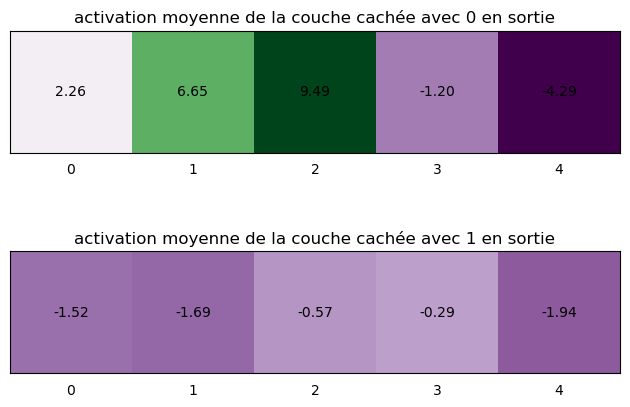

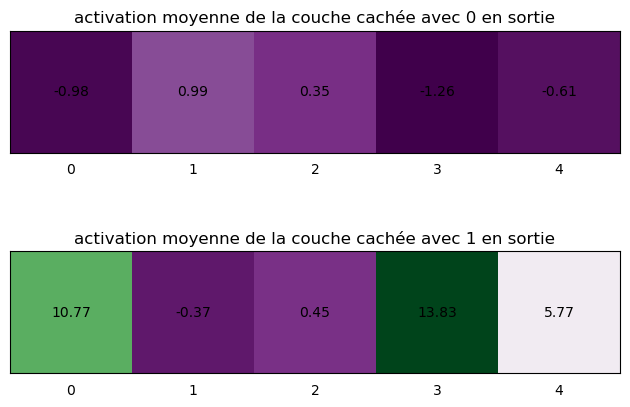

In [22]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def print_activation(name, output):
    act = activation[name].squeeze()
    act_ones  = torch.where(output==1, act, torch.zeros(act.size()))
    act_zeros = torch.where(output==0, act, torch.zeros(act.size()))

    mean_ones  = torch.mean(act_ones, dim=0)
    mean_zeros = torch.mean(act_zeros, dim=0)

    # print(mean_ones, mean_zeros)
    fig, ax = plt.subplots(2, 1)
    tick_kw = {'left': False, 'bottom': False, 'labelleft': False}


    min_act = min(mean_ones.min().item(), mean_zeros.min().item())
    max_act = max(mean_ones.max().item(), mean_zeros.max().item())

    color_map = 'PRGn'

    ax[0].imshow(mean_zeros.unsqueeze(0), cmap=color_map, vmin=min_act, vmax=max_act)
    ax[0].tick_params(**tick_kw)
    ax[0].set_title("activation moyenne de la couche cachée avec 0 en sortie")

    ax[1].imshow(mean_ones.unsqueeze(0), cmap=color_map, vmin=min_act, vmax=max_act)
    ax[1].tick_params(**tick_kw)
    ax[1].set_title("activation moyenne de la couche cachée avec 1 en sortie")

    for i, (v0, v1) in enumerate(zip(mean_zeros, mean_ones)):
        ax[0].text(i, 0, f"{v0.item():.2f}", ha="center", va="center")
        ax[1].text(i, 0, f"{v1.item():.2f}", ha="center", va="center")
    
    fig.tight_layout()
    plt.show()

bnet.hi.eval()
bnet.hi.l1.register_forward_hook(get_activation('l1_hi'))
output = bnet.hi(x_train).detach()
print_activation('l1_hi', output)
bnet.lo.eval()
bnet.lo.l1.register_forward_hook(get_activation('l1_lo'))
output = bnet.lo(x_train).detach()
print_activation('l1_lo', output)

#### Confusion matrix

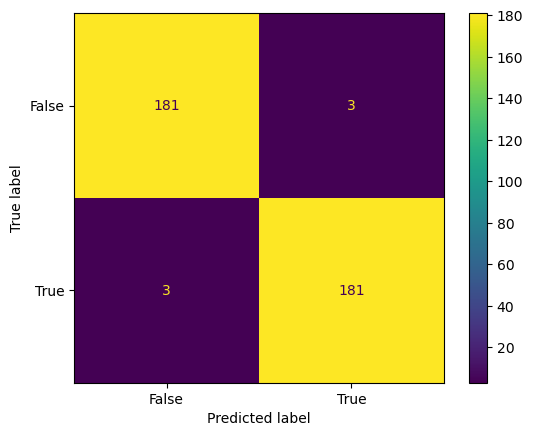

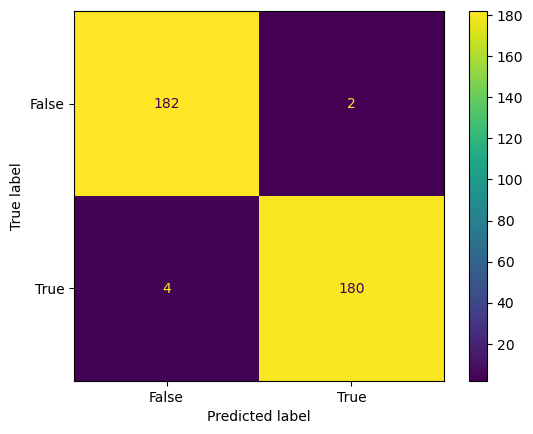

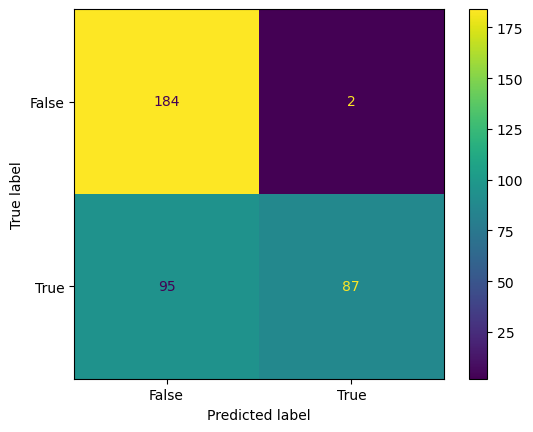

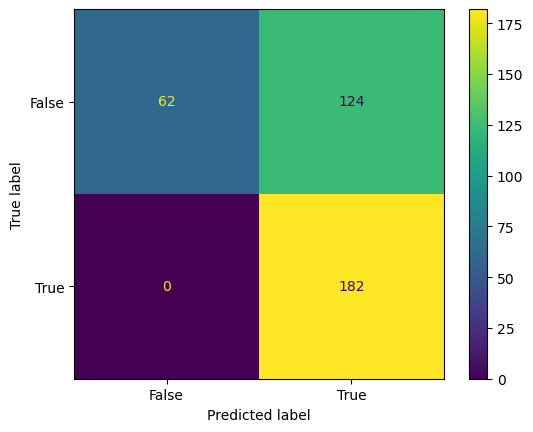

In [23]:
bnet.eval()
y_pred = bnet(x_train)
y_pred_wh = y_pred["wh"].detach() # prediction for whole nns combined with the logical layer
y_pred_nn = y_pred["nn"].detach() # prediction for accurate nn
y_pred_hi = y_pred["hi"].detach() # prediction for high approximation
y_pred_lo = y_pred["lo"].detach() # prediction for low approximation

plot_cm(y_train, y_pred_wh)
plot_cm(y_train, y_pred_nn)
plot_cm(y_pred_nn, y_pred_hi)
plot_cm(y_pred_nn, y_pred_lo)
plt.show()

#### Coverage / F1-score

In [18]:
def cov_score(y_true, y_pred):
    labels = np.unique(y_true)
    scores = {}

    for label in labels:
        indices_true = np.where(y_true == label)[0]
        indices_pred = np.where(y_pred == label)[0]
        scores[label] = len(np.intersect1d(indices_true, indices_pred))/len(indices_true)

    return scores

f1_wh = metrics.f1_score(y_train, y_pred_wh)
f1_nn = metrics.f1_score(y_train, y_pred_nn)
print(f"f1 score whole nns : {f1_wh:.3f} | f1 score nn : {f1_nn:.3f}")
cov_hi = cov_score(y_pred_nn, y_pred_hi)
cov_lo = cov_score(y_pred_nn, y_pred_lo)
print(f"cov 1 by high approx : {cov_hi[1]:.3f} | cov 0 by low approx : {cov_lo[0]:.3f}")

f1 score whole nns : 0.978 | f1 score nn : 0.978
cov 1 by high approx : 0.817 | cov 0 by low approx : 0.000


#### degrade nn performance (slightly if approx are already close to nn)

In [19]:
""" new target for the big nn """
hi_target = torch.where(torch.logical_and(y_pred_nn == 0, y_pred_hi == 1), torch.full(y_pred_nn.size(), 1), y_pred_nn)
# print(torch.logical_and(y_pred_nn == 0, y_pred_hi == 1).nonzero())
hilo_target = torch.where(torch.logical_and(y_pred_nn == 1, y_pred_lo == 0), torch.full(y_pred_nn.size(), 0), hi_target)
# print(torch.logical_and(y_pred_nn == 1, y_pred_lo == 0).nonzero())

max_epoch = 5000
learning_rate = 1e-2

optimizer = Adam(bnet.nn.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bnet.nn.train()
    y_pred = bnet.nn(x_train)
    loss_nn = loss_nn_tr(y_pred, hilo_target)

    bnet.nn.zero_grad()
    loss_nn.backward()
    optimizer.step()

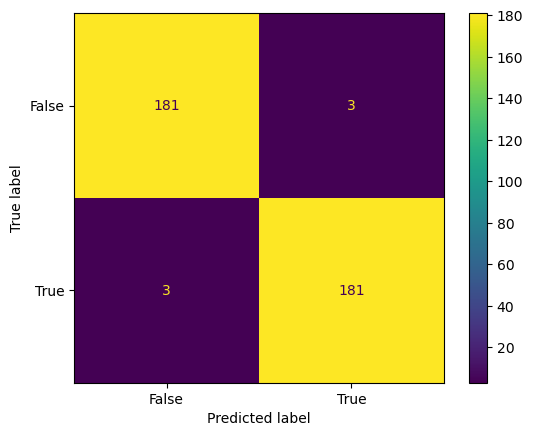

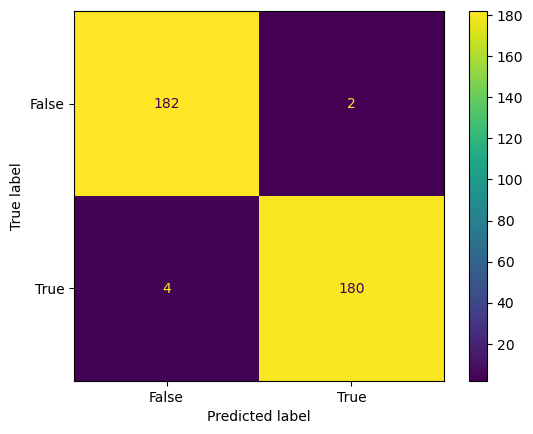

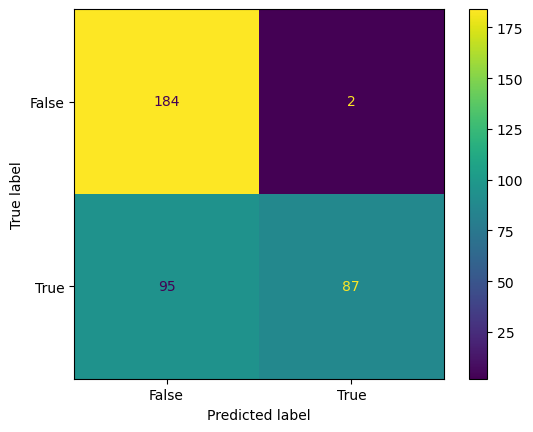

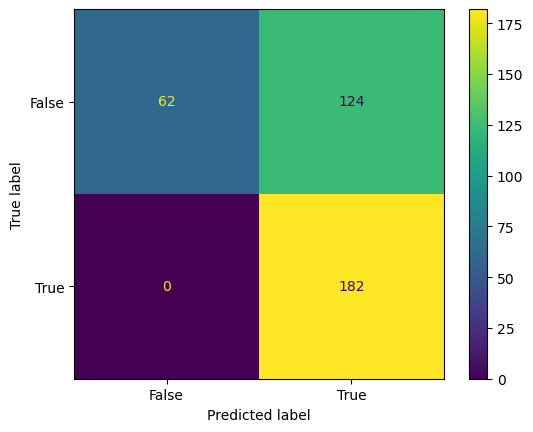

In [24]:
bnet.eval()
y_pred = bnet(x_train)
y_pred_wh = y_pred["wh"].detach()
y_pred_nn = y_pred["nn"].detach()
y_pred_hi = y_pred["hi"].detach()
y_pred_lo = y_pred["lo"].detach()

plot_cm(y_train, y_pred_wh)
plot_cm(y_train, y_pred_nn)
plot_cm(y_pred_nn, y_pred_hi)
plot_cm(y_pred_nn, y_pred_lo)
plt.show()